https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb

In [1]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch

print_config()
set_determinism(seed=0)

2025-11-12 11:41:02.215687792 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"


MONAI version: 1.6.dev2542
Numpy version: 2.1.2
Pytorch version: 2.8.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 612f3dd3cba4d73cfcea4b5329079e20aa31523d
MONAI __file__: /home/<username>/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.23.0+cu126
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.3.2
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For d

In [2]:
directory = "./seg_ckpts"
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

./seg_ckpts


In [3]:
# Corrected conversion for FeTS labels
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    FeTS/BraTS label mapping (ints on disk): 0=background, 1=NCR/NET, 2=edema, 4=enhancing (ET)
    Build 3-channel multi-label [TC, WT, ET]:
      TC = (label==1) OR (label==4)
      WT = (label==1) OR (label==2) OR (label==4)
      ET = (label==4)
    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            lab = d[key]
            tc = torch.logical_or(lab == 1, lab == 4)
            wt = torch.logical_or(torch.logical_or(lab == 1, lab == 2), lab == 4)
            et = (lab == 4)
            d[key] = torch.stack([tc, wt, et], dim=0).float()
        return d


# Transforms/Preprocessing taken as is from MONAI

In [4]:
# class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
#     """
#     Convert labels to multi channels based on brats classes:
#     label 1 is the peritumoral edema
#     label 2 is the GD-enhancing tumor
#     label 3 is the necrotic and non-enhancing tumor core
#     The possible classes are TC (Tumor core), WT (Whole tumor)
#     and ET (Enhancing tumor).

#     """

#     def __call__(self, data):
#         d = dict(data)
#         for key in self.keys:
#             result = []
#             # merge label 2 and label 3 to construct TC
#             result.append(torch.logical_or(d[key] == 2, d[key] == 3))
#             # merge labels 1, 2 and 3 to construct WT
#             result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
#             # label 2 is ET
#             result.append(d[key] == 2)
#             d[key] = torch.stack(result, axis=0).float()
#         return d

train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.


# Load the data in a federated manner ready for the Data Valuation pipeline

In [5]:
# MINE!!

import os, copy, time, random, torch, numpy as np                                 
import glob
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from monai.data import CacheDataset
import glob, nibabel as nib, pandas as pd
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Orientationd, ScaleIntensityd,
    RandFlipd, RandSpatialCropd, Compose, SelectItemsd
)

from utils import *
  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# -----------------------------------------------------------
# 0. paths & meta-data (unchanged) ---------------------------
# -----------------------------------------------------------
BRATS_DIR = "/mnt/d/Datasets/FETS_data/MICCAI_FeTS2022_TrainingData"
CSV_PATH  = f"{BRATS_DIR}/partitioning_1.csv"
MODALITIES = ["flair", "t1", "t1ce", "t2"]
LABEL_KEY  = "seg"

# -----------------------------------------------------------
# 1. read partition file  ➜  { id : [subjects] } ------------
# -----------------------------------------------------------
part_df       = pd.read_csv(CSV_PATH)
partition_map = (
    part_df.groupby("Partition_ID")["Subject_ID"]
           .apply(list).to_dict()
)                               # keys are 1 … 23

# VAL_CENTRES = {16, 17, 18, 19, 20, 21, 22, 23}          # ← our hold-out set
VAL_CENTRES = {22, 23}          # ← our sanity set

# split once, reuse everywhere
train_partitions = {cid: sids for cid, sids in partition_map.items()
                    if cid not in VAL_CENTRES}
val_subjects     = sum((partition_map[cid] for cid in VAL_CENTRES), [])

# -----------------------------------------------------------
# 2. helper to build MONAI-style record dicts ----------------
# -----------------------------------------------------------

def build_records(subject_ids):
    recs = []
    for sid in subject_ids:
        sdir = f"{BRATS_DIR}/{sid}"
        images = [f"{sdir}/{sid}_{m}.nii.gz" for m in MODALITIES]  # 4 modalities
        recs.append({"image": images, "label": f"{sdir}/{sid}_{LABEL_KEY}.nii.gz"})
    return recs


# -----------------------------------------------------------
# 3. MONAI CacheDatasets ------------------------------------
# -----------------------------------------------------------
# ── client-wise training sets ───────────────────────────────
CUT_OFF, FRAC, SEED = 4, 0.1, 42
rng = random.Random(SEED)

train_datasets = {}
for cid, subj_ids in train_partitions.items():
    if cid > CUT_OFF:                                    # keep your cap
        break
    k = max(1, int(len(subj_ids) * FRAC))                # e.g. 30 %
    sample_ids = rng.sample(subj_ids, k)
    train_datasets[cid] = CacheDataset(
        build_records(sample_ids), transform=train_transform, cache_rate=1
    )

# ── single validation dataset made from *all* val subjects ─
val_dataset = CacheDataset(
    build_records(val_subjects), transform=val_transform, cache_rate=1
)

print("train per-centre sizes:", {k: len(v) for k, v in train_datasets.items()})
print("validation size:", len(val_dataset))


Loading dataset: 100%|██████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.06s/it]

train per-centre sizes: {1: 51, 2: 1, 3: 1, 4: 4}
validation size: 12


In [6]:
# ── Check raw label integer values for a handful of validation cases ──
import os, random, nibabel as nib, numpy as np

raw_label_paths = []
for rec in val_dataset.data:  # CacheDataset stores the *pre-transform* dicts here
    lp = rec["label"]
    # If some pipelines wrap labels in a list, normalize to string:
    if isinstance(lp, (list, tuple)): lp = lp[0]
    raw_label_paths.append(str(lp))

random.shuffle(raw_label_paths)
check_n = min(10, len(raw_label_paths))
print(f"Checking raw label uniques for {check_n} validation cases...\n")
global_counts = {}

for i, p in enumerate(raw_label_paths[:check_n], 1):
    arr = nib.load(p).get_fdata().astype(np.int16)
    u = np.unique(arr)
    print(f"{i:02d}. {os.path.basename(p)} -> uniques: {u.tolist()}")
    # tally voxels per ID
    for v in u:
        global_counts[v] = global_counts.get(v, 0) + int((arr == v).sum())

print("\nGlobal voxel counts across inspected cases:")
for k in sorted(global_counts):
    print(f"  label {k}: {global_counts[k]}")


Checking raw label uniques for 10 validation cases...

01. FeTS2022_01033_seg.nii.gz -> uniques: [0, 1, 2, 4]
02. FeTS2022_01150_seg.nii.gz -> uniques: [0, 1, 2, 4]
03. FeTS2022_01149_seg.nii.gz -> uniques: [0, 1, 2, 4]
04. FeTS2022_00126_seg.nii.gz -> uniques: [0, 1, 2, 4]
05. FeTS2022_01148_seg.nii.gz -> uniques: [0, 1, 2, 4]
06. FeTS2022_01030_seg.nii.gz -> uniques: [0, 1, 2, 4]
07. FeTS2022_00118_seg.nii.gz -> uniques: [0, 1, 2, 4]
08. FeTS2022_01147_seg.nii.gz -> uniques: [0, 1, 2, 4]
09. FeTS2022_01029_seg.nii.gz -> uniques: [0, 1, 2, 4]
10. FeTS2022_01031_seg.nii.gz -> uniques: [0, 1, 2, 4]

Global voxel counts across inspected cases:
  label 0: 88352624
  label 1: 74241
  label 2: 591660
  label 4: 261475


In [8]:
# Presence/voxel count report over the *transformed* val set
import torch, os, pandas as pd
from torch.utils.data import DataLoader

def presence_report(dataset, batch_size=1, max_cases=None):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    rows, n_seen = [], 0
    with torch.no_grad():
        for batch in loader:
            y = batch["label"]                  # [B,3,D,H,W] from the *converter*
            ids = batch.get("label_meta_dict", {}).get("filename_or_obj", [f"case_{n_seen+i}" for i in range(y.shape[0])])
            for b in range(y.shape[0]):
                m = y[b]
                vox_tc = int(m[0].sum().item())
                vox_wt = int(m[1].sum().item())
                vox_et = int(m[2].sum().item())
                rows.append({
                    "case": os.path.basename(str(ids[b])),
                    "vox_TC": vox_tc, "vox_WT": vox_wt, "vox_ET": vox_et,
                    "has_TC": int(vox_tc > 0), "has_WT": int(vox_wt > 0), "has_ET": int(vox_et > 0),
                })
                n_seen += 1
                if max_cases and n_seen >= max_cases:
                    break
            if max_cases and n_seen >= max_cases:
                break
    df = pd.DataFrame(rows)
    total = len(df)
    sTC, sWT, sET = df["has_TC"].sum(), df["has_WT"].sum(), df["has_ET"].sum()
    print(f"Total cases scanned: {total}")
    print(f"Cases with TC: {sTC} ({100*sTC/total:.1f}%)")
    print(f"Cases with WT: {sWT} ({100*sWT/total:.1f}%)")
    print(f"Cases with ET: {sET} ({100*sET/total:.1f}%)")
    print("\nExamples with ET absent:")
    print(df.loc[df["has_ET"]==0, ["case","vox_TC","vox_WT","vox_ET"]].head(10).to_string(index=False))
    return df

df_presence = presence_report(val_dataset, batch_size=1)


Total cases scanned: 12
Cases with TC: 12 (100.0%)
Cases with WT: 12 (100.0%)
Cases with ET: 12 (100.0%)

Examples with ET absent:
Empty DataFrame
Columns: [case, vox_TC, vox_WT, vox_ET]
Index: []


Case 0 | sagittal x=91 (0..154) | plane voxels: TC=220, WT=1328, ET=178, TC_only=42, ET_only=0


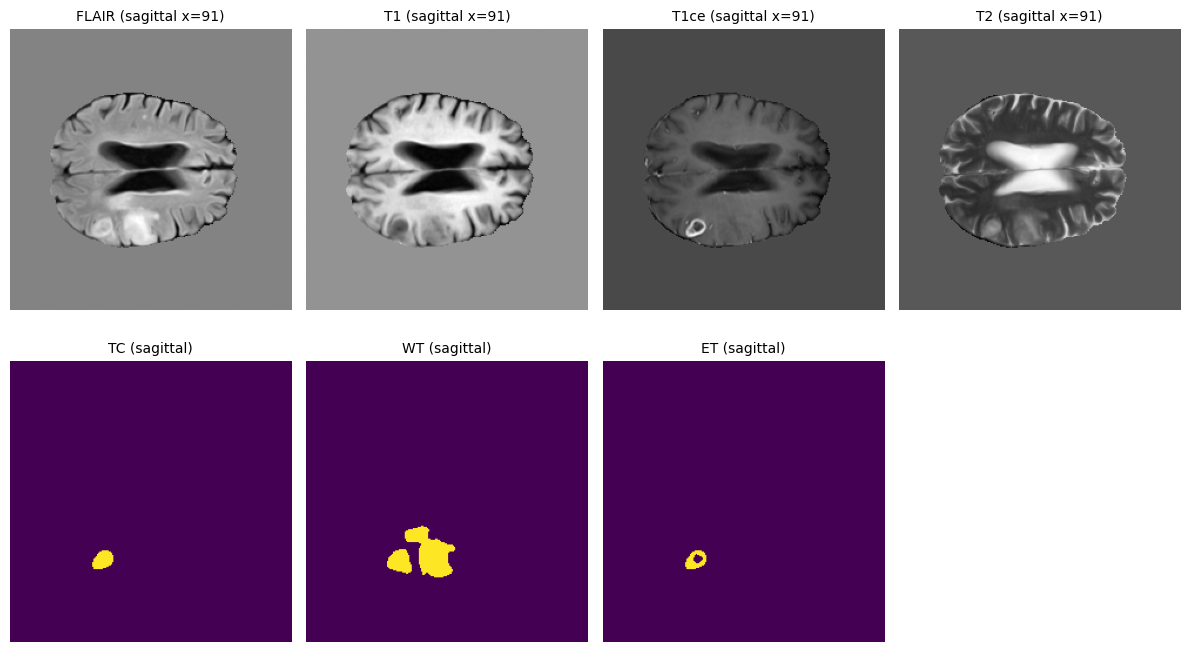

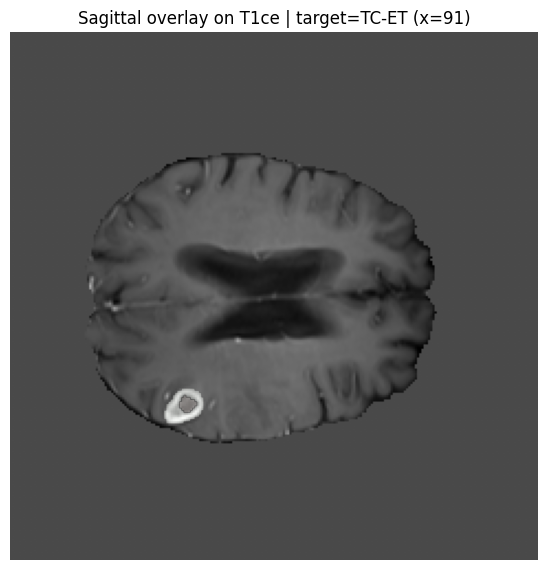

In [14]:
# ─────────────────────────────────────────────────────────────
# Sagittal-only visualization with exclusives  [C, D, H, W]
# ─────────────────────────────────────────────────────────────
import os, numpy as np, torch
import matplotlib.pyplot as plt

MOD_NAMES = ["FLAIR", "T1", "T1ce", "T2"]
LAB_NAMES = ["TC", "WT", "ET"]
LAB_IDX   = {"TC": 0, "WT": 1, "ET": 2}

def pick_sagittal_x(label_3dhw: torch.Tensor, target="ET") -> int:
    """
    Pick sagittal index x (along W axis) maximizing target.
    target in {"ET","WT","TC","TC-ET"}; for "TC-ET" we maximize NCR/NET-only.
    label_3dhw shape: [3, D, H, W]
    """
    tc = (label_3dhw[0] > 0.5)  # [D,H,W]
    et = (label_3dhw[2] > 0.5)
    if target.upper() == "TC-ET":
        tgt = tc & ~et                               # NCR/NET-only
        per_x = tgt.sum(dim=(0,1))                   # sum over D,H -> [W]
    else:
        c = LAB_IDX[target.upper()]
        tgt = (label_3dhw[c] > 0.5)
        per_x = tgt.sum(dim=(0,1))                   # [W]
    x = int(torch.argmax(per_x).item()) if per_x.numel() else 0
    W = label_3dhw.shape[3]
    return max(0, min(x, W - 1))

def visualize_sagittal_exclusive(dataset, index=0, slice_target="TC-ET", overlay_mod="T1ce", alpha=0.35, save_dir=None):
    """
    Shows sagittal slice (left↔right) for a single case.
    slice_target: "ET" | "WT" | "TC" | "TC-ET" (emphasize NCR/NET).
    Overlays: red = TC-only (NCR/NET), green = overlap (ET), blue = ET-only (typically empty).
    """
    sample = dataset[index]
    img = sample["image"]   # [4, D, H, W]
    lab = sample["label"]   # [3, D, H, W]
    C, D, H, W = img.shape

    # choose sagittal index
    x = pick_sagittal_x(lab, target=slice_target)

    img_np = img.cpu().numpy()                      # [4,D,H,W]
    lab_np = (lab.cpu().numpy() > 0.5).astype(np.uint8)  # [3,D,H,W]

    # sagittal background (D×H)
    mods = [img_np[m, :, :, x] for m in range(4)]
    # masks at sagittal slice
    tc = lab_np[0, :, :, x].astype(bool)   # [D,H]
    wt = lab_np[1, :, :, x].astype(bool)
    et = lab_np[2, :, :, x].astype(bool)

    # exclusives (on this sagittal plane)
    tc_only = np.logical_and(tc, ~et)      # NCR/NET-only
    et_only = np.logical_and(et, ~tc)      # should be empty (ET ⊆ TC)
    overlap = np.logical_and(tc, et)       # ET

    print(
        f"Case {index} | sagittal x={x} (0..{W-1}) | plane voxels: "
        f"TC={int(tc.sum())}, WT={int(wt.sum())}, ET={int(et.sum())}, "
        f"TC_only={int(tc_only.sum())}, ET_only={int(et_only.sum())}"
    )

    # ----- Figure 1: 4 modalities + 3 masks at sagittal x
    fig1 = plt.figure(figsize=(12, 7))
    for i, (title, slc) in enumerate(zip(MOD_NAMES, mods)):
        ax = fig1.add_subplot(2, 4, i + 1)
        ax.imshow(slc, cmap="gray"); ax.set_title(f"{title} (sagittal x={x})", fontsize=10); ax.axis("off")
    for i, (title, slc) in enumerate(zip(["TC","WT","ET"], [tc, wt, et])):
        ax = fig1.add_subplot(2, 4, 4 + i + 1)
        ax.imshow(slc, vmin=0, vmax=1); ax.set_title(f"{title} (sagittal)", fontsize=10); ax.axis("off")
    plt.tight_layout()

    # ----- Figure 2: overlay (D×H) with exclusives
    mod_idx = MOD_NAMES.index(overlay_mod)
    bg = img_np[mod_idx, :, :, x]
    fig2, ax = plt.subplots(1, 1, figsize=(5.8, 5.8))
    ax.imshow(bg, cmap="gray")
    ax.imshow(np.ma.masked_where(~tc_only,  tc_only),  cmap="Reds",   alpha=alpha)  # TC-only
    ax.imshow(np.ma.masked_where(~overlap,  overlap),  cmap="Greens", alpha=alpha)  # ET (overlap)
    ax.imshow(np.ma.masked_where(~et_only,  et_only),  cmap="Blues",  alpha=alpha)  # ET-only (likely empty)
    ax.set_title(f"Sagittal overlay on {overlay_mod} | target={slice_target} (x={x})")
    ax.axis("off")
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        base = os.path.splitext(os.path.basename(str(sample['label'].meta.get('filename_or_obj', f'case_{index}'))))[0]
        fig1.savefig(os.path.join(save_dir, f"{base}_sagittal_mods_masks_x{x}.png"), dpi=150, bbox_inches="tight")
        fig2.savefig(os.path.join(save_dir, f"{base}_sagittal_overlay_{overlay_mod}_x{x}.png"), dpi=150, bbox_inches="tight")

    plt.show()

# Examples:
# emphasize NCR/NET by choosing x with maximal TC-ET
visualize_sagittal_exclusive(val_dataset, index=0, slice_target="TC-ET", overlay_mod="T1ce", alpha=0.35)
# or emphasize ET:
# visualize_sagittal_exclusive(val_dataset, index=0, slice_target="ET", overlay_mod="T1ce", alpha=0.35)
# sweep a few:
# for i in range(3):
#     visualize_sagittal_exclusive(val_dataset, index=i, slice_target="TC-ET", overlay_mod="FLAIR", alpha=0.35)


# Create Model, Loss, Optimizer (as is from MONAI tutorial)


In [18]:
max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
global_model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(global_model.parameters(), 1e-4, weight_decay=1e-5)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=global_model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.autocast("cuda"):
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.GradScaler("cuda")
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [ ]:
# # Peek one training sample after transforms:
# s0 = train_datasets[idxs_users[0]][0]  # first client, first sample
# img = s0["image"]                       # should be Torch tensor [4, D, H, W]
# lab = s0["label"]                       # should be [3, D, H, W] in your custom order [TC, WT, ET]

# print("image type/shape:", type(img), getattr(img, "shape", None))
# print("label type/shape:", type(lab), getattr(lab, "shape", None))

# # Per-channel stats (if these are nearly identical, something is wrong upstream)
# import torch
# with torch.no_grad():
#     means = [img[c].float().mean().item() for c in range(img.shape[0])]
#     stds  = [img[c].float().std().item()  for c in range(img.shape[0])]
# print("per-modality mean:", [f"{m:.4f}" for m in means])
# print("per-modality std:",  [f"{s:.4f}" for s in stds])

# # Quick correlation check between modalities (if ~1.0 across pairs, they are the same volume)
# def corr(a, b):
#     a = a.flatten().float(); b = b.flatten().float()
#     a = (a - a.mean()) / (a.std() + 1e-8)
#     b = (b - b.mean()) / (b.std() + 1e-8)
#     return float((a * b).mean().item())
# for i in range(4):
#     for j in range(i+1, 4):
#         print(f"corr(mod{i}, mod{j}) =", f"{corr(img[i], img[j]):.3f}")


In [ ]:
# # Label uniqueness:
# with torch.no_grad():
#     ch_sums = [int(lab[c].sum().item()) for c in range(lab.shape[0])]
# print("label voxel counts [TC, WT, ET]:", ch_sums)
# # Typically WT >= TC >= ET and they should differ between channels.


# Evaluation function

In [19]:
def evaluate_model(model, dataset, device, batch_size=1):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    dice_metric.reset()
    model.eval()
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            inputs = batch["image"].to(device)
            labels = batch["label"].to(device)          # already multi-channel (WT/TC/ET) floats

            # sliding-window inference (your helper)
            logits = inference(inputs)                  # [B, 3, D, H, W]

            # tensor-wise post-processing (no decollate, no meta juggling)
            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).float()

            # accumulate Dice on tensors directly
            dice_metric(y_pred=preds, y=labels)
            dice_metric_batch(y_pred=preds, y=labels)

    mean_dice = dice_metric.aggregate().item()
    metric_batch = dice_metric_batch.aggregate()
    metric_tc = metric_batch[0].item()
    metric_wt = metric_batch[1].item()
    metric_et = metric_batch[2].item()
    dice_metric.reset()
    dice_metric_batch.reset()
    
    return mean_dice, metric_tc, metric_wt, metric_et
    
print("Dice before any training:", evaluate_model(global_model, val_dataset, device)) # quick sanity check


Evaluating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.08it/s]

Dice before any training: (0.01810482144355774, 0.024675803259015083, 0.0006372256320901215, 0.02900143712759018)


# Train federated

In [20]:
from tqdm.auto import tqdm, trange   # trange == tqdm(range())
from collections import OrderedDict

def average_weights(state_dicts, fractions):
    """
    Federated averaging with client fractions (must sum to 1).
    state_dicts: list of state_dicts (same keys)
    fractions:   list of floats, same length, sum≈1
    """
    avg_sd = OrderedDict()
    for k in state_dicts[0].keys():
        avg = 0.0
        for sd, w in zip(state_dicts, fractions):
            avg += sd[k] * w
        avg_sd[k] = avg
    return avg_sd

# ────────────────────────────────────────────────────────────
# 1. one-client update (returns weights + mean loss)          │
# ────────────────────────────────────────────────────────────
def local_train(model, loader, device, lr=1e-4, epochs=1):
    """
    Train a local copy of the global model on one client's DataLoader.
    Uses your DiceLoss (multi-label, sigmoid) and full crops from transforms.
    """
    model = copy.deepcopy(model).to(device)
    model.train()

    # reuse your loss choice; or inline DiceLoss the same way
    crit = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True,
                    to_onehot_y=False, sigmoid=True).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    epoch_losses = []

    for _ in range(epochs):
        running = 0.0
        for batch in loader:
            img = batch["image"].to(device)   # [B, 4, D, H, W]
            msk = batch["label"].to(device)   # [B, 3, D, H, W]

            opt.zero_grad(set_to_none=True)
            logits = model(img)               # [B, 3, D, H, W]
            loss = crit(logits, msk)
            loss.backward()
            opt.step()

            running += float(loss.item())
        epoch_losses.append(running / max(1, len(loader)))

    return model.state_dict(), float(np.mean(epoch_losses))


# ────────────────────────────────────────────────────────────
# 2. FedAvg training loop (simple tqdm + clean prints)        │
# ────────────────────────────────────────────────────────────
from tqdm.auto import tqdm, trange

ROUNDS, LOCAL_EPOCHS, LR, BATCH = 100, 1, 1e-4, 1

idxs_users = list(train_datasets.keys())
sizes      = {k: len(ds) for k, ds in train_datasets.items()}
total_n    = sum(sizes.values())
fractions  = [sizes[k] / total_n for k in idxs_users]

print("Dice before any training:", evaluate_model(global_model, val_dataset, device))

best_metric = -1
best_metric_round = -1
best_metrics_rounds_and_time = [[], [], []]
round_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for rnd in trange(1, ROUNDS + 1, desc="Global rounds", position=0, leave=True, dynamic_ncols=True):
    local_weights, client_losses = [], []

    # client bar (line 1)
    for cid in tqdm(idxs_users, desc=" clients", position=1, leave=False, total=len(idxs_users), dynamic_ncols=True):
        loader = DataLoader(train_datasets[cid], batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
        w, loss = local_train(global_model, loader, device, lr=LR, epochs=LOCAL_EPOCHS)
        local_weights.append(w); client_losses.append(loss)

    global_model.load_state_dict(average_weights(local_weights, fractions))

    # eval bar (line 2)
    mean_dice, metric_tc, metric_wt, metric_et = evaluate_model(global_model, val_dataset, device)
    
    metric_values.append(mean_dice)
    metric_values_tc.append(metric_tc)
    metric_values_wt.append(metric_wt)
    metric_values_et.append(metric_et)
    
    mean_loss = float(np.mean(client_losses))
    round_loss_values.append(mean_loss)


    if mean_dice > best_metric:
        best_metric = mean_dice
        best_metric_round = rnd
        best_metrics_rounds_and_time[0].append(best_metric)
        best_metrics_rounds_and_time[1].append(best_metric_round)
        best_metrics_rounds_and_time[2].append(time.time() - total_start)
        torch.save(
            global_model.state_dict(),
            os.path.join(root_dir, "best_metric_model.pth"),
        )
        print("saved new best metric model")
        
    tqdm.write(
        f"Round {rnd:02d}: mean-loss={mean_loss:.4f} "
        f"mean-Dice={mean_dice:.4f}  "
        f"TC-Dice={metric_tc:.4f}  WT-Dice={metric_wt:.4f}  ET-Dice={metric_et:.4f}"
    )



Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Dice before any training: (0.01810482144355774, 0.024675803259015083, 0.0006372256320901215, 0.02900143712759018)


Global rounds:   0%|                                                                             | 0/50 [00:00…

 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 01: mean-loss=0.9634 mean-Dice=0.1930  TC-Dice=0.0081  WT-Dice=0.5641  ET-Dice=0.0070


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 02: mean-loss=0.9063 mean-Dice=0.2225  TC-Dice=0.0081  WT-Dice=0.6525  ET-Dice=0.0068


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 03: mean-loss=0.8965 mean-Dice=0.2222  TC-Dice=0.0081  WT-Dice=0.6516  ET-Dice=0.0068


 clients:   0%|                                                                                   | 0/4 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 04: mean-loss=0.8893 mean-Dice=0.2505  TC-Dice=0.0081  WT-Dice=0.7341  ET-Dice=0.0092


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 05: mean-loss=0.8860 mean-Dice=0.2666  TC-Dice=0.0081  WT-Dice=0.6877  ET-Dice=0.1041


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 06: mean-loss=0.8805 mean-Dice=0.3166  TC-Dice=0.0081  WT-Dice=0.7415  ET-Dice=0.2003


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 07: mean-loss=0.8719 mean-Dice=0.2835  TC-Dice=0.0081  WT-Dice=0.6462  ET-Dice=0.1964


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 08: mean-loss=0.8685 mean-Dice=0.3236  TC-Dice=0.0081  WT-Dice=0.7206  ET-Dice=0.2422


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 09: mean-loss=0.8603 mean-Dice=0.3114  TC-Dice=0.0081  WT-Dice=0.6820  ET-Dice=0.2441


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 10: mean-loss=0.8574 mean-Dice=0.3134  TC-Dice=0.0081  WT-Dice=0.6882  ET-Dice=0.2440


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 11: mean-loss=0.8484 mean-Dice=0.3627  TC-Dice=0.0081  WT-Dice=0.7933  ET-Dice=0.2868


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 12: mean-loss=0.8425 mean-Dice=0.3346  TC-Dice=0.0081  WT-Dice=0.7264  ET-Dice=0.2694


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 13: mean-loss=0.8364 mean-Dice=0.3458  TC-Dice=0.0081  WT-Dice=0.7509  ET-Dice=0.2784


 clients:   0%|                                                                                   | 0/4 [00:00…

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 14: mean-loss=0.8284 mean-Dice=0.3819  TC-Dice=0.0081  WT-Dice=0.8243  ET-Dice=0.3133


 clients:   0%|                                                                                   | 0/4 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 15: mean-loss=0.8228 mean-Dice=0.3353  TC-Dice=0.0081  WT-Dice=0.7269  ET-Dice=0.2710


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 16: mean-loss=0.8157 mean-Dice=0.3680  TC-Dice=0.0081  WT-Dice=0.7984  ET-Dice=0.2976


 clients:   0%|                                                                                   | 0/4 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 17: mean-loss=0.8065 mean-Dice=0.3858  TC-Dice=0.0083  WT-Dice=0.8356  ET-Dice=0.3135


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 18: mean-loss=0.7984 mean-Dice=0.3907  TC-Dice=0.0955  WT-Dice=0.7837  ET-Dice=0.2929


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 19: mean-loss=0.7929 mean-Dice=0.4624  TC-Dice=0.2790  WT-Dice=0.8080  ET-Dice=0.3002


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 20: mean-loss=0.7884 mean-Dice=0.5099  TC-Dice=0.3402  WT-Dice=0.8566  ET-Dice=0.3328


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 21: mean-loss=0.7743 mean-Dice=0.5194  TC-Dice=0.3648  WT-Dice=0.8539  ET-Dice=0.3395


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 22: mean-loss=0.7681 mean-Dice=0.4568  TC-Dice=0.3183  WT-Dice=0.7568  ET-Dice=0.2952


 clients:   0%|                                                                                   | 0/4 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 23: mean-loss=0.7638 mean-Dice=0.5023  TC-Dice=0.3490  WT-Dice=0.8345  ET-Dice=0.3234


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 24: mean-loss=0.7529 mean-Dice=0.5282  TC-Dice=0.3787  WT-Dice=0.8613  ET-Dice=0.3446


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 25: mean-loss=0.7445 mean-Dice=0.4804  TC-Dice=0.3320  WT-Dice=0.8036  ET-Dice=0.3055


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 26: mean-loss=0.7381 mean-Dice=0.5235  TC-Dice=0.3767  WT-Dice=0.8508  ET-Dice=0.3428


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 27: mean-loss=0.7303 mean-Dice=0.5356  TC-Dice=0.3910  WT-Dice=0.8622  ET-Dice=0.3535


 clients:   0%|                                                                                   | 0/4 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 28: mean-loss=0.7221 mean-Dice=0.5351  TC-Dice=0.3857  WT-Dice=0.8688  ET-Dice=0.3509


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 29: mean-loss=0.7183 mean-Dice=0.5163  TC-Dice=0.3630  WT-Dice=0.8583  ET-Dice=0.3277


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 30: mean-loss=0.7139 mean-Dice=0.5135  TC-Dice=0.3650  WT-Dice=0.8453  ET-Dice=0.3302


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 31: mean-loss=0.7085 mean-Dice=0.5519  TC-Dice=0.4056  WT-Dice=0.8836  ET-Dice=0.3666


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 32: mean-loss=0.6979 mean-Dice=0.5325  TC-Dice=0.3835  WT-Dice=0.8685  ET-Dice=0.3456


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 33: mean-loss=0.6967 mean-Dice=0.5305  TC-Dice=0.3896  WT-Dice=0.8514  ET-Dice=0.3506


 clients:   0%|                                                                                   | 0/4 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
: AssertionErrorcan only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 34: mean-loss=0.6931 mean-Dice=0.5518  TC-Dice=0.4094  WT-Dice=0.8810  ET-Dice=0.3648


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 35: mean-loss=0.6801 mean-Dice=0.5578  TC-Dice=0.4113  WT-Dice=0.8953  ET-Dice=0.3668


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 36: mean-loss=0.6729 mean-Dice=0.5333  TC-Dice=0.3879  WT-Dice=0.8637  ET-Dice=0.3481


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 37: mean-loss=0.6720 mean-Dice=0.5017  TC-Dice=0.3655  WT-Dice=0.8158  ET-Dice=0.3238


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 38: mean-loss=0.6668 mean-Dice=0.5299  TC-Dice=0.3907  WT-Dice=0.8495  ET-Dice=0.3496


 clients:   0%|                                                                                   | 0/4 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 39: mean-loss=0.6613 mean-Dice=0.5361  TC-Dice=0.3960  WT-Dice=0.8594  ET-Dice=0.3530


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 40: mean-loss=0.6512 mean-Dice=0.5390  TC-Dice=0.3976  WT-Dice=0.8666  ET-Dice=0.3527


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 41: mean-loss=0.6548 mean-Dice=0.5808  TC-Dice=0.4685  WT-Dice=0.8656  ET-Dice=0.4083


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 42: mean-loss=0.6593 mean-Dice=0.5246  TC-Dice=0.3867  WT-Dice=0.8417  ET-Dice=0.3453


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 43: mean-loss=0.6399 mean-Dice=0.5806  TC-Dice=0.4572  WT-Dice=0.8803  ET-Dice=0.4042


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 44: mean-loss=0.6237 mean-Dice=0.5507  TC-Dice=0.4059  WT-Dice=0.8854  ET-Dice=0.3608


 clients:   0%|                                                                                   | 0/4 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 45: mean-loss=0.6275 mean-Dice=0.5472  TC-Dice=0.4028  WT-Dice=0.8791  ET-Dice=0.3597


 clients:   0%|                                                                                   | 0/4 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe53a3f3520>
Traceback (most recent call last):
  File "/home/locolinux2/miniconda3/envs/m_quant_py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
 

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 46: mean-loss=0.6264 mean-Dice=0.5644  TC-Dice=0.4313  WT-Dice=0.8791  ET-Dice=0.3827


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 47: mean-loss=0.6162 mean-Dice=0.5469  TC-Dice=0.4069  WT-Dice=0.8684  ET-Dice=0.3656


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 48: mean-loss=0.6174 mean-Dice=0.5728  TC-Dice=0.4324  WT-Dice=0.8964  ET-Dice=0.3896


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

saved new best metric model
Round 49: mean-loss=0.6181 mean-Dice=0.5946  TC-Dice=0.4779  WT-Dice=0.8791  ET-Dice=0.4269


 clients:   0%|                                                                                   | 0/4 [00:00…

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Round 50: mean-loss=0.5936 mean-Dice=0.5831  TC-Dice=0.4400  WT-Dice=0.8953  ET-Dice=0.4139


Saved curves to: ./seg_ckpts/plots/training_curves.csv


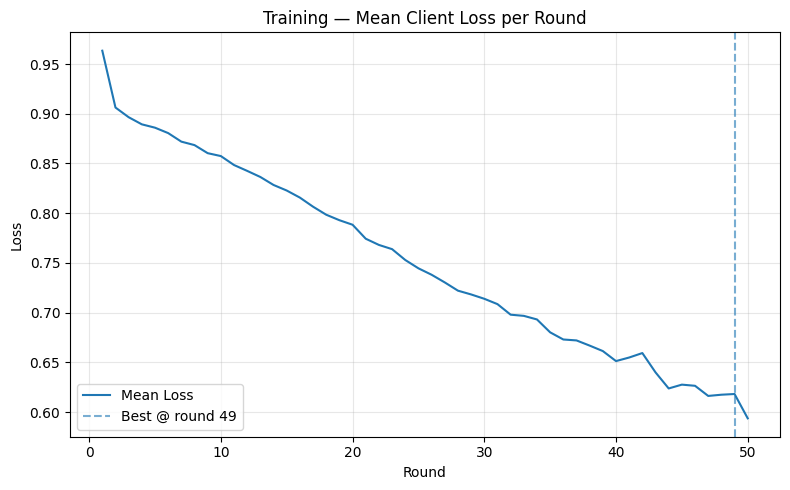

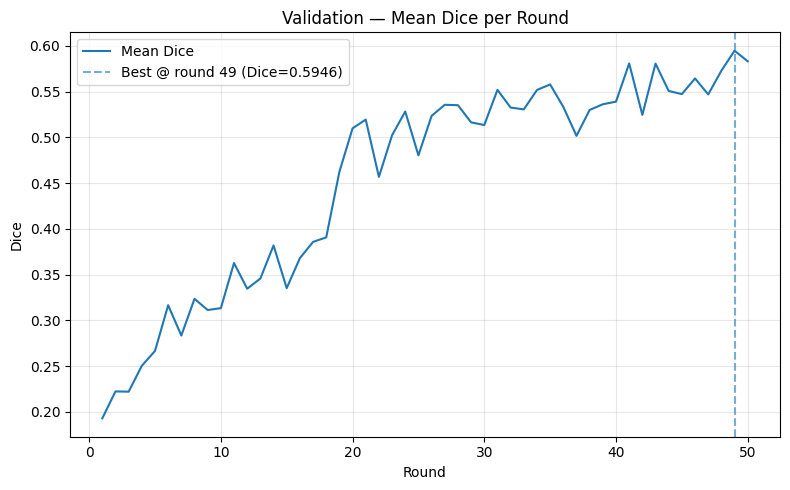

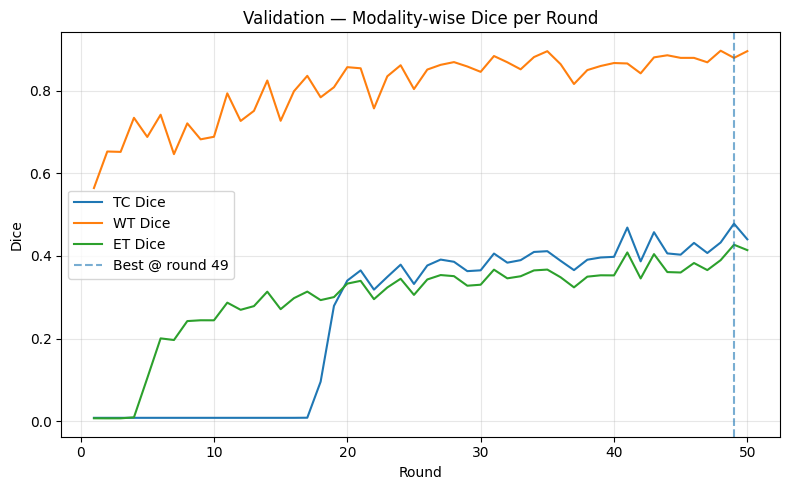

Plots saved in: ./seg_ckpts/plots


In [21]:
# ─────────────────────────────────────────────────────────────
# Plot training curves (loss, mean Dice, and class-wise Dice)
# ─────────────────────────────────────────────────────────────
import os, math, time
import numpy as np
import matplotlib.pyplot as plt

# Optional: smoothing (moving average). Set SMOOTH=0 to disable.
SMOOTH = 0  # e.g., 3 or 5 for light smoothing

def _moving_avg(x, k):
    if k is None or k <= 1:
        return np.asarray(x, dtype=float)
    x = np.asarray(x, dtype=float)
    kernel = np.ones(k, dtype=float) / k
    # pad on both sides to keep length
    pad = k // 2
    xpad = np.pad(x, (pad, pad), mode="edge")
    return np.convolve(xpad, kernel, mode="valid")[: len(x)]

rounds = np.arange(1, len(round_loss_values) + 1, dtype=int)

loss_curve     = _moving_avg(round_loss_values, SMOOTH)
mean_dice_curve= _moving_avg(metric_values, SMOOTH)
tc_curve       = _moving_avg(metric_values_tc, SMOOTH)
wt_curve       = _moving_avg(metric_values_wt, SMOOTH)
et_curve       = _moving_avg(metric_values_et, SMOOTH)

# Some runs may not have found a "best" yet; guard accordingly.
_has_best = "best_metric" in globals() and "best_metric_round" in globals() and best_metric_round is not None and best_metric_round != -1

# Where to save artifacts
plots_dir = os.path.join(root_dir if "root_dir" in globals() else ".", "plots")
os.makedirs(plots_dir, exist_ok=True)
csv_path = os.path.join(plots_dir, "training_curves.csv")

# Save curves as CSV for reproducibility
try:
    import pandas as pd
    df = pd.DataFrame({
        "round": rounds,
        "mean_loss": np.asarray(round_loss_values, dtype=float),
        "mean_dice": np.asarray(metric_values, dtype=float),
        "tc_dice":   np.asarray(metric_values_tc, dtype=float),
        "wt_dice":   np.asarray(metric_values_wt, dtype=float),
        "et_dice":   np.asarray(metric_values_et, dtype=float),
    })
    df.to_csv(csv_path, index=False)
    print(f"Saved curves to: {csv_path}")
except Exception as e:
    print(f"(Skipping CSV save; pandas not available or error: {e})")

# 1) Mean client loss per round
plt.figure(figsize=(8, 5))
plt.plot(rounds, loss_curve, label="Mean Loss")
if _has_best and 1 <= best_metric_round <= rounds[-1]:
    plt.axvline(best_metric_round, linestyle="--", alpha=0.6, label=f"Best @ round {best_metric_round}")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Training — Mean Client Loss per Round")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "loss_curve.png"), dpi=150)
plt.show()

# 2) Mean Dice (overall)
plt.figure(figsize=(8, 5))
plt.plot(rounds, mean_dice_curve, label="Mean Dice")
if _has_best and 1 <= best_metric_round <= rounds[-1]:
    plt.axvline(best_metric_round, linestyle="--", alpha=0.6, label=f"Best @ round {best_metric_round} (Dice={best_metric:.4f})")
plt.xlabel("Round")
plt.ylabel("Dice")
plt.title("Validation — Mean Dice per Round")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "mean_dice_curve.png"), dpi=150)
plt.show()

# 3) Class-wise Dice (TC / WT / ET)
plt.figure(figsize=(8, 5))
plt.plot(rounds, tc_curve, label="TC Dice")
plt.plot(rounds, wt_curve, label="WT Dice")
plt.plot(rounds, et_curve, label="ET Dice")
if _has_best and 1 <= best_metric_round <= rounds[-1]:
    plt.axvline(best_metric_round, linestyle="--", alpha=0.6, label=f"Best @ round {best_metric_round}")
plt.xlabel("Round")
plt.ylabel("Dice")
plt.title("Validation — Modality-wise Dice per Round")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "classwise_dice_curve.png"), dpi=150)
plt.show()

print("Plots saved in:", plots_dir)


Loaded best weights from: ./seg_ckpts/best_metric_model.pth

Per-class Dice on first 5 val cases:
  idx 00 ▸ TC 0.177 | WT 0.919 | ET 0.179 | mean 0.425
  idx 01 ▸ TC 0.562 | WT 0.914 | ET 0.514 | mean 0.663
  idx 02 ▸ TC 0.657 | WT 0.899 | ET 0.598 | mean 0.718
  idx 03 ▸ TC 0.622 | WT 0.926 | ET 0.513 | mean 0.687
  idx 04 ▸ TC 0.294 | WT 0.959 | ET 0.279 | mean 0.511
Case 0 | Dice — TC:0.177  WT:0.919  ET:0.179  mean:0.425 | sagittal x=87


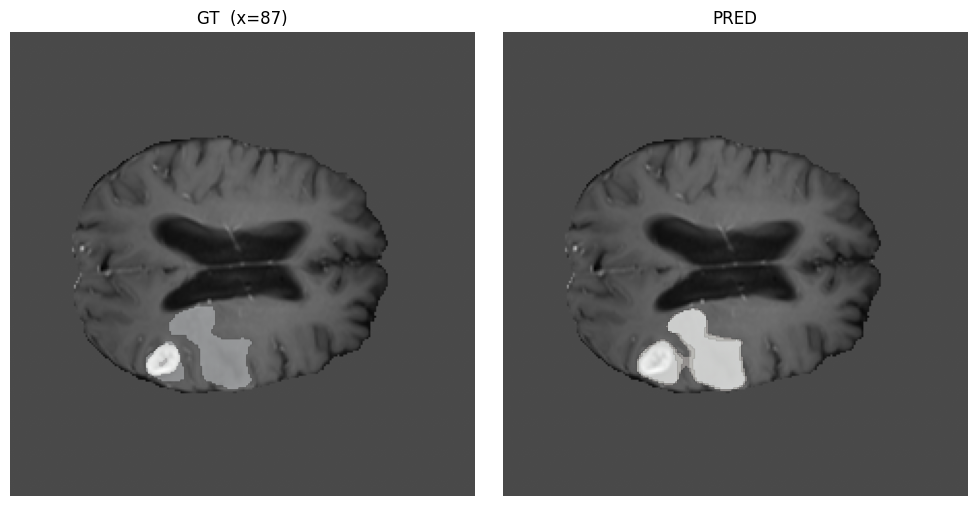

In [22]:
# ─────────────────────────────────────────────────────────────
# Load best model → run inference → compare GT vs PRED (TC/WT/ET)
# ─────────────────────────────────────────────────────────────
import os, torch, numpy as np, matplotlib.pyplot as plt

# 1) load best weights (same path you used when saving)
best_path = os.path.join(root_dir, "best_metric_model.pth")
assert os.path.exists(best_path), f"Missing {best_path}"
state = torch.load(best_path, map_location=device)
global_model.load_state_dict(state)
global_model.eval()
print(f"Loaded best weights from: {best_path}")

MOD_NAMES = ["FLAIR", "T1", "T1ce", "T2"]
LAB_IDX   = {"TC": 0, "WT": 1, "ET": 2}

@torch.no_grad()
def predict_case(sample, thresh=0.5):
    """
    sample: dict with "image" [4,D,H,W]
    returns: pred_bin [3,D,H,W] float {0,1}
    """
    x = sample["image"].unsqueeze(0).to(device)        # [1,4,D,H,W]
    logits = inference(x)                              # [1,3,D,H,W]
    probs  = torch.sigmoid(logits)[0]                  # [3,D,H,W]
    pred   = (probs > thresh).float().cpu()
    return pred

def dice_binary(pred, target, eps=1e-8):
    inter = (pred * target).sum().item()
    denom = pred.sum().item() + target.sum().item()
    return (2.0 * inter) / (denom + eps)

def per_class_dice(pred_bin, gt_bin):
    # pred_bin, gt_bin: [3,D,H,W] (floats 0/1)
    d_tc = dice_binary(pred_bin[0], gt_bin[0])
    d_wt = dice_binary(pred_bin[1], gt_bin[1])
    d_et = dice_binary(pred_bin[2], gt_bin[2])
    return d_tc, d_wt, d_et, (d_tc + d_wt + d_et)/3.0

def pick_sagittal_x(label_3dhw: torch.Tensor, target="ET") -> int:
    """
    Pick sagittal index x (along W) maximizing target area.
    target ∈ {"ET","WT","TC","TC-ET"}; "TC-ET" emphasizes NCR/NET-only.
    """
    tc = (label_3dhw[0] > 0.5)
    et = (label_3dhw[2] > 0.5)
    if target.upper() == "TC-ET":
        tgt = tc & ~et
        per_x = tgt.sum(dim=(0,1))  # [W]
    else:
        c = LAB_IDX[target.upper()]
        tgt = (label_3dhw[c] > 0.5)
        per_x = tgt.sum(dim=(0,1))
    x = int(torch.argmax(per_x).item()) if per_x.numel() else 0
    W = label_3dhw.shape[3]
    return max(0, min(x, W - 1))

def visualize_compare_sagittal(dataset, index=0, slice_target="ET", overlay_mod="T1ce", alpha=0.35, save_dir=None):
    """
    Side-by-side overlays (GT vs PRED) on the same **sagittal** slice.
    Colors: red=TC, green=ET, blue=WT (so ET stands out distinctly from TC).
    """
    sample = dataset[index]
    img   = sample["image"]           # [4,D,H,W]
    gt    = sample["label"]           # [3,D,H,W] (TC,WT,ET)
    pred  = predict_case(sample)      # [3,D,H,W]

    # choose sagittal index
    x = pick_sagittal_x(gt, target=slice_target)
    m_idx = MOD_NAMES.index(overlay_mod)

    img_np  = img.cpu().numpy()
    gt_np   = (gt.cpu().numpy()   > 0.5).astype(np.uint8)
    pred_np = (pred.cpu().numpy() > 0.5).astype(np.uint8)

    bg = img_np[m_idx, :, :, x]              # [D,H] plane

    # slice masks (D×H) — GT
    tc_g, wt_g, et_g = gt_np[0, :, :, x], gt_np[1, :, :, x], gt_np[2, :, :, x]
    # slice masks — PRED
    tc_p, wt_p, et_p = pred_np[0, :, :, x], pred_np[1, :, :, x], pred_np[2, :, :, x]

    # per-class dice on full volume
    d_tc, d_wt, d_et, d_mean = per_class_dice(torch.from_numpy(pred_np), torch.from_numpy(gt_np))
    print(f"Case {index} | Dice — TC:{d_tc:.3f}  WT:{d_wt:.3f}  ET:{d_et:.3f}  mean:{d_mean:.3f} | sagittal x={x}")

    def overlay(ax, bg, tc, wt, et, title):
        ax.imshow(bg, cmap="gray")
        ax.imshow(np.ma.masked_where(tc==0, tc), cmap="Reds",   alpha=alpha)   # TC
        ax.imshow(np.ma.masked_where(et==0, et), cmap="Greens", alpha=alpha)   # ET
        ax.imshow(np.ma.masked_where(wt==0, wt), cmap="Blues",  alpha=alpha)   # WT
        ax.set_title(title); ax.axis("off")

    # plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    overlay(axs[0], bg, tc_g, wt_g, et_g, f"GT  (x={x})")
    overlay(axs[1], bg, tc_p, wt_p, et_p, "PRED")
    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        base = os.path.splitext(os.path.basename(str(sample['label'].meta.get('filename_or_obj', f'case_{index}'))))[0]
        out = os.path.join(save_dir, f"{base}_sag_compare_{overlay_mod}_x{x}.png")
        plt.savefig(out, dpi=150, bbox_inches="tight")
        print(f"Saved {out}")

    plt.show()

# ── Quick run: print Dice for a few and visualize one ─────────────────
# summarize first N cases
N = min(5, len(val_dataset))
scores = []
for i in range(N):
    gt = val_dataset[i]["label"]
    pred = predict_case(val_dataset[i])
    d_tc, d_wt, d_et, d_mean = per_class_dice(pred, gt)
    scores.append((i, d_tc, d_wt, d_et, d_mean))
print("\nPer-class Dice on first", N, "val cases:")
for (i, a,b,c,m) in scores:
    print(f"  idx {i:02d} ▸ TC {a:.3f} | WT {b:.3f} | ET {c:.3f} | mean {m:.3f}")

# visualize one case (try ET emphasis first; switch to 'TC-ET' to see NCR/NET)
visualize_compare_sagittal(val_dataset, index=0, slice_target="ET",    overlay_mod="T1ce", alpha=0.35, save_dir=None)
# visualize_compare_sagittal(val_dataset, index=0, slice_target="TC-ET", overlay_mod="T1ce", alpha=0.35, save_dir=None)

